<a href="https://colab.research.google.com/github/wittenator/pimai/blob/master/src/notebook/src/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  from google.colab import files
  !pip install torch torchvision skorch
  !pip install hypertools
  colab = True
except:
  colab = False

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from scipy.signal import sawtooth
from multiprocessing import cpu_count

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset, DataLoader

from torch.distributions import *

import skorch
import numpy as np
import hypertools as hyp
import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline
#torch.autograd.set_detect_anomaly(True)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Dataset

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if use_cuda else {}

mnist_train = datasets.MNIST('/data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_test = datasets.MNIST('/data', train=False, transform=transforms.Compose([transforms.ToTensor()]))

prob = 0.05
train_occluded = np.array([1] * int(len(mnist_train)*prob) + [0] * int((1-prob)*len(mnist_train)))
test_occluded = np.array([1] * int(len(mnist_test)*prob) + [0] * int((1-prob)*len(mnist_test)))
np.random.shuffle(train_occluded)
np.random.shuffle(test_occluded)


mnist_train_occluded =datasets.MNIST('/data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_train_occluded.targets[train_occluded] = -1
mnist_test_occluded = datasets.MNIST('/data', train=False, transform=transforms.Compose([transforms.ToTensor()]))
mnist_test_occluded.targets[test_occluded] = -1



train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=True, **kwargs)

train_loader_occluded = DataLoader(mnist_train_occluded, batch_size=128, shuffle=True, **kwargs)
test_loader_occluded = DataLoader(mnist_test_occluded, batch_size=1000, shuffle=True, **kwargs)


## Generic autoencoder class

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        now = datetime.now()
        current_time = now.strftime("%Y%m%d-%H%M%S")
        self.writer = SummaryWriter(log_dir="/data/runs/"+current_time)
        self.embeddings = []
        self.embedding_labels =[]
    
    def trains(self, device, train_loader, optimizer, epoch, epochs):
        self.train()
        loss_sum = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = self.compute_loss_train(data, target, epoch, epochs)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            self.writer.add_scalar('Loss/train', loss.item(), epoch*len(train_loader)+batch_idx)
            
    def tests(self, device, test_loader, epoch, epochs):
        self.eval()
        test_loss = 0
        recon = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                loss, output = self.compute_loss_test(data, target, epoch, epochs)
                test_loss += loss
                recon += F.binary_cross_entropy_with_logits(output, data.view(-1, 784), reduction='none').sum(axis=1).mean()

        test_loss /= len(test_loader.dataset)
        recon /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Reconstruction error: {}\n'.format(
            test_loss, recon))
        
    def add_embedding(self, loader):
        import hypertools as hyp
        with torch.no_grad():
            labels = []
            embs = []
            for data, label in loader:
                data, label = data.to(device), label.to(device)
                labels.append(label)
                _, a, b, *rest = self(data)
                emb = self.reparameterize(a,b)
                embs.append(emb)
            self.embeddings.append(torch.cat(tuple(embs), dim=0).cpu().numpy())
            self.embedding_labels = torch.cat(tuple(labels), dim=0).cpu().numpy()
            
    def visualize_embeddings(self, epoch):
        hyp.plot(self.embeddings[epoch], '.', hue=self.embedding_labels, reduce='TSNE', ndims=2, save_path=f'/data/visualizations/{self.__class__.__name__}-{datetime.now().strftime("%Y%m%d-%H%M%S")}.svg' if not colab else None)

## Gaussian Variational Autoencoder

In [25]:
class VAE(Autoencoder):
    def __init__(self, k=50):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, k)
        self.fc22 = nn.Linear(500, k)
        self.fc3 = nn.Linear(k, 500)
        self.fc4 = nn.Linear(500, 784)

    def encode(self, x):
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD
    
    def compute_loss_train(self, data, target, epoch, epochs):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar)
    
    def compute_loss_test(self, data, target, epoch, epochs):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar).item(), recon_batch  # sum up batch loss

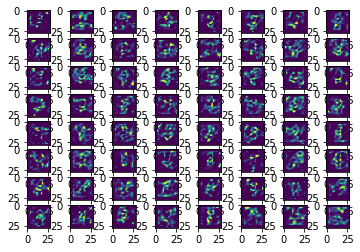

In [37]:
vae = VAE(k=50).to(device)
vae.load_state_dict(torch.load("/data/vae-500-50--none--50--km/vae-100-50--none--50--km.pth", map_location=device))
sample = torch.randn(64, 50).to(device)
sample = vae.decode(sample).reshape(64, 28, 28).cpu().detach().numpy()
f, axarr = plt.subplots(8,8)
for i in range(64):
  axarr[i//8,i%8].imshow(sample[i])

## Stick-breaking process

In [5]:
def stickbreakingprocess(a, b):
    eps = 10*torch.finfo(torch.float).eps #smalles representable number such that 1.0 + eps != 1.0
    batch_size = a.size()[0]
    
    uniform_samples = Uniform(torch.tensor([eps]), torch.tensor([1.0-eps])).rsample(a.size()).squeeze().to(device) if not use_cuda else torch.cuda.FloatTensor(a.size(0), a.size(1)).uniform_().clamp(eps, 1.0-eps)
    exp_a = torch.reciprocal(a) #returns a new tensor with the reciprocal of the elements of input: out_i = 1/input_i
    exp_b = torch.reciprocal(b)
    #value for Kumaraswamy distribution
    km = (1- uniform_samples.pow(exp_b) + eps).pow(exp_a)
    
    #no Nans are allowed in the matrix
    #assert not torch.isnan(km).any().item()
    
    # concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be empty.
    cumprods = torch.cat((torch.ones([batch_size, 1], device=device), torch.cumprod(1-km, axis=1)), dim=1)
    sticks = cumprods[:,:-1]*km # cumulative product of elements along a given axis
    sticks[:, -1] = 1- sticks[:, :-1].sum(axis=1) 
    return sticks

In [6]:
stickbreakingprocess(torch.rand(10,20).to(device), torch.rand(10,20).to(device)).sum(axis=1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Stick-breaking Autoencoder

In [7]:
class SBVAE(Autoencoder):
    def __init__(self, k):
        super(SBVAE, self).__init__()
        self.k = k

        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, self.k)
        self.fc22 = nn.Linear(500, self.k)
        
        
        self.fc3 = nn.Linear(self.k, 500)
        self.fc4 = nn.Linear(500, 784)

        self.prior_alpha = torch.Tensor([1]).to(device)
        self.prior_beta = torch.Tensor([5]).to(device)

    def encode(self, x):
        x = torch.flatten(x, 1)
        h1 = F.leaky_relu(self.fc1(x))
        return F.softplus(self.fc21(h1)), F.softplus(self.fc22(h1))

    def reparameterize(self, a, b):
        eps = 10*torch.finfo(torch.float).eps #smalles representable number such that 1.0 + eps != 1.0
        batch_size = a.size()[0]
        
        uniform_samples = Uniform(torch.tensor([eps]), torch.tensor([1.0-eps])).rsample(a.size()).squeeze().to(device) if not use_cuda else torch.cuda.FloatTensor(a.size(0), a.size(1)).uniform_().clamp(eps, 1.0-eps)
        exp_a = torch.reciprocal(a) #returns a new tensor with the reciprocal of the elements of input: out_i = 1/input_i
        exp_b = torch.reciprocal(b)
        #value for Kumaraswamy distribution
        km = (1- uniform_samples.pow(exp_b) + eps).pow(exp_a)
        
        #no Nans are allowed in the matrix
        #assert not torch.isnan(km).any().item()
        
        # concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be empty.
        cumprods = torch.cat((torch.ones([batch_size, 1], device=device), torch.cumprod(1-km, axis=1)), dim=1)
        sticks = cumprods[:,:-1]*km # cumulative product of elements along a given axis
        sticks[:, -1] = 1- sticks[:, :-1].sum(axis=1) 
        return sticks

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        a, b = self.encode(x)
        z = self.reparameterize(a, b)
        return self.decode(z), a, b
    
    def Beta(self, a,b):
        return torch.exp(torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b))

    def KLD(self, a,b, prior_alpha, prior_beta):
        ab = (a*b)
        kl = 1/(1+ab) * self.Beta(1/a, b)
        kl += 1/(2+ab) * self.Beta(2/a, b)
        kl += 1/(3+ab) * self.Beta(3/a, b)
        kl += 1/(4+ab) * self.Beta(4/a, b)
        kl += 1/(5+ab) * self.Beta(5/a, b)
        kl += 1/(6+ab) * self.Beta(6/a, b)
        kl += 1/(7+ab) * self.Beta(7/a, b)
        kl += 1/(8+ab) * self.Beta(8/a, b)
        kl += 1/(9+ab) * self.Beta(9/a, b)
        kl += 1/(10+ab) * self.Beta(10/a, b)
        kl *= (prior_beta-1)*b
                                                                                                                                            
        kl += (a-prior_alpha)/a * (-np.euler_gamma - torch.digamma(b) - 1/b) #T.psi(self.posterior_b)                                                                                        

        # add normalization constants                                                                                                                                                                
        kl += torch.log(ab) + torch.log(self.Beta(prior_alpha, prior_beta))

        # final term                                                                                                                                                                                 
        kl += -(b-1)/b 

        return kl
    
    def loss_function(self, recon_x, x, a, b, prior_alpha, prior_beta, epoch, epochs):
        period = 20
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction='none')
        KLD = self.KLD(a,b, prior_alpha, prior_beta)

        return len(train_loader)/a.size(0) * torch.mean(1/period*(epoch%period)*KLD.sum(axis=1) + BCE.sum(axis=1))
    
    def compute_loss_train(self, data, target, epoch, epochs):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, self.prior_alpha, self.prior_beta, epoch, epochs)
    
    def compute_loss_test(self, data, target, epoch, epochs):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, self.prior_alpha, self.prior_beta, epoch, epochs).item(), recon_batch 

In [16]:
sbvae = SBVAE(k=50).to(device)
sbvae.load_state_dict(torch.load("/data/sbvae-500-50--cycle--50--gamma/sbvae-500-50--cycle--50--gamma.pth", map_location=device))

<All keys matched successfully>

In [17]:
with torch.no_grad():
    labels = []
    embs = []
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        labels.append(label)
        _, a, b, *rest = sbvae(data)
        emb = sbvae.reparameterize(a,b)
        embs.append(emb)
    emb = (torch.cat(tuple(embs), dim=0).cpu().numpy())
    labels = torch.cat(tuple(labels), dim=0).cpu().numpy()
    hyp.plot(emb, '.', hue=labels, reduce='TSNE', ndims=2, save_path=f'/data/sbvae-{datetime.now().strftime("%Y%m%d-%H%M%S")}.svg' if not colab else None)

KeyboardInterrupt: 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


<BarContainer object of 50 artists>

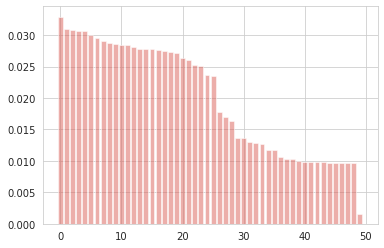

In [18]:
norms = torch.norm(sbvae.fc3.weight, p=2, dim=0).detach().numpy()
norms.sort()
norms = norms[::-1]/norms.sum()
cums = np.cumsum(norms)
for i, cum in enumerate(cums):
    if cum < 0.99 * norms.sum():
        print(i)
plt.bar(range(len(norms)), norms, align='center', alpha=0.5)

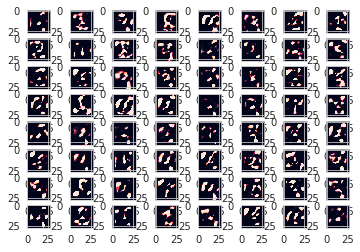

In [20]:
from torch.distributions.beta import Beta
sample = Beta(torch.tensor([1.0]), torch.tensor([5.0])).rsample([64,50]).squeeze().to(device)
cumprods = torch.cat((torch.ones([64, 1], device=device), torch.cumprod(1-sample, axis=1)), dim=1)
sample = cumprods[:,:-1]*sample
sample[:, -1] = 1- sample[:, :-1].sum(axis=1)
sample = torch.sigmoid(sbvae.decode(sample)).reshape(64, 28, 28).cpu().detach().numpy()
f, axarr = plt.subplots(8,8)
for i in range(64):
  axarr[i//8,i%8].imshow(sample[i])

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def test_vae_acc(weights_path):
    sbvae = SBVAE(k=50).to(device)
    sbvae.load_state_dict(torch.load(weights_path, map_location=device))
    with torch.no_grad():
        labels = []
        embs = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            labels.append(label)
            _, a, b, *rest = sbvae(data)
            emb = sbvae.reparameterize(a,b)
            embs.append(emb)
        emb_train = (torch.cat(tuple(embs), dim=0).cpu().numpy())
        labels_train = torch.cat(tuple(labels), dim=0).cpu().numpy()

    with torch.no_grad():
        labels = []
        embs = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            labels.append(label)
            _, a, b, *rest = sbvae(data)
            emb = sbvae.reparameterize(a,b)
            embs.append(emb)
        emb_test = (torch.cat(tuple(embs), dim=0).cpu().numpy())
        labels_test = torch.cat(tuple(labels), dim=0).cpu().numpy()

    accs = []
    for n in [3,5,10]:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(emb_train,labels_train)
        accs.append(1-accuracy_score(labels_test, knn.predict(emb_test)))
    
    return accs

print(test_vae_acc("/data/sbvae-1000-50--none--50--km-.pth"))

[0.8124, 0.7996333333333333, 0.7835833333333333]


In [8]:
class SSSBVAE(SBVAE):
    def __init__(self, k):
        super(SSSBVAE, self).__init__(k)
  
        self.fc23 = nn.Linear(500, 10)
        self.fc3 = nn.Linear(self.k + 10, 500)

    def encode(self, x):
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return F.softplus(self.fc21(h1)), F.softplus(self.fc22(h1)), F.softplus(self.fc23(h1))

    def forward(self, x):
        a, b, y = self.encode(x)
        z = self.reparameterize(a, b)
        z = torch.cat((z, y/torch.norm(y, p=1)),dim=1)
        return self.decode(z), a, b, y/torch.norm(y, p=1)
    
    def loss_function(self, recon_x, x, a, b, y, y_true, prior_alpha, prior_beta, epoch, epochs):
        period = 20
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction='none')
        KLD = self.KLD(a,b, prior_alpha, prior_beta)

        log_y = F.binary_cross_entropy(y, torch.eye(10, device=device)[y_true], reduction='none').sum(axis=1)
        ent_y = Categorical(probs=y).entropy()

        y_recon = torch.where(y_true !=-1, log_y, ent_y)

        eye_batch = torch.eye(10, device=device).unsqueeze(0).expand(a.size(0), -1, -1)
        y_batch = y.unsqueeze(2).expand(-1, -1, 10)

        factor = torch.where(y_true !=-1, torch.ones(a.size(0), device=device), F.binary_cross_entropy(y_batch, eye_batch, reduction='none').sum(axis=(1,2))) 

        term = 1/period*(epoch%period)*KLD.sum(axis=1) + BCE.sum(axis=1)*factor + y_recon

        return len(train_loader)/a.size(0) * (torch.mean(term))

    def compute_loss_train(self, data, target, epoch, epochs):
        recon_batch, a, b, y = self(data)
        return self.loss_function(recon_batch, data, a, b, y, target, self.prior_alpha, self.prior_beta, epoch, epochs)
    
    def compute_loss_test(self, data, target, epoch, epochs):
        recon_batch, a, b, y = self(data)
        return self.loss_function(recon_batch, data, a, b, y, target, self.prior_alpha, self.prior_beta, epoch, epochs).item(), recon_batch 

In [10]:
sssbvae = SSSBVAE(k=50).to(device)
sssbvae.load_state_dict(torch.load("/data/sssbvae-10-50--none--50--km--0.01/sssbvae-10-50--none--50--km.pth", map_location=device))

<All keys matched successfully>

[7 7 2 6 6 3 4 0 6 7 4 4 4 5 8 3 1 3 6 5 5 9 4 3 9 3 2 3 0 6 6 5 1 8 7 0 3
 6 8 1 0 1 9 2 5 2 0 5 6 9 5 8 2 7 9 9 3 0 4 0 3 4 4 3]


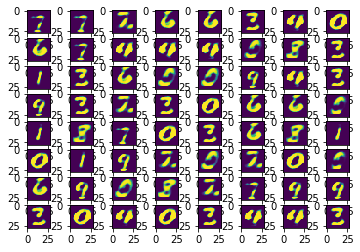

In [11]:
sample = Beta(torch.tensor([1.0]), torch.tensor([5.0])).rsample([64,50]).squeeze().to(device)
nums = np.random.randint(10, size=64)
onehot = torch.eye(10, device=device)[nums]

cumprods = torch.cat((torch.ones([64, 1], device=device), torch.cumprod(1-sample, axis=1)), dim=1)
sample = cumprods[:,:-1]*sample
sample[:, -1] = 1- sample[:, :-1].sum(axis=1)
print(nums)
inputs = torch.cat((sample, onehot), dim=1)
sample = torch.sigmoid(sssbvae.decode(inputs)).reshape(64, 28, 28).cpu().detach().numpy()
f, axarr = plt.subplots(8,8)
for i in range(64):
  axarr[i//8,i%8].imshow(sample[i])

In [ ]:
eps = 5 * torch.finfo(torch.float).eps 
a = Uniform(torch.tensor([eps]), torch.tensor([1.0 - eps])).rsample(torch.tensor([60,50]))
b = Uniform(torch.tensor([eps]), torch.tensor([1.0 - eps])).rsample(torch.tensor([60,50]))
uniform_samples = Uniform(torch.tensor([eps]), torch.tensor([1.0 - eps])).rsample(torch.tensor([60,50])).squeeze().to(
            device)
print(uniform_samples.size())
dist = torch.stack([torch.histc(uniform_samples, bins=100, min=0, max=1) for a,b in zip(a,b)])
dist = dist / dist.sum(axis=1).unsqueeze(1).expand(a.size(0), 100)
kl = torch.nn.KLDivLoss(dist, dist, reduction='batchmean')
print(dist.sum(axis=1))

[1 5 2 3 1 6 6 8 6 0 7 0 7 3 5 8 0 2 5 5 8 3 9 5 1 5 2 0 3 2 3 9 5 5 4 0 1
 5 0 1 7 6 0 7 5 8 9 6 0 3 1 7 0 5 9 6 3 0 4 9 3 3 3 1]


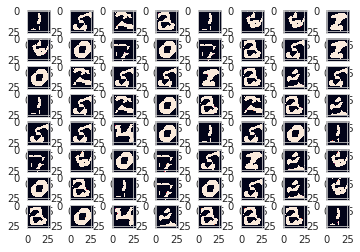

In [34]:
eps = 5 * torch.finfo(torch.float).eps 
a = Uniform(torch.tensor([eps]), torch.tensor([1.0 - eps])).rsample(torch.tensor([60,50]))
b = Uniform(torch.tensor([eps]), torch.tensor([1.0 - eps])).rsample(torch.tensor([60,50]))
uniform_samples = Uniform(torch.tensor([eps]), torch.tensor([1.0 - eps])).rsample(torch.tensor([60,50])).squeeze().to(
            device)
print(uniform_samples.size())
dist = torch.stack([torch.histc(uniform_samples, bins=100, min=0, max=1) for a,b in zip(a,b)])
dist = dist / dist.sum(axis=1).unsqueeze(1).expand(a.size(0), 100)
kl = torch.nn.KLDivLoss(dist, dist, reduction='batchmean')
print(dist.sum(axis=1))

torch.Size([60, 50])


RuntimeError: bool value of Tensor with more than one value is ambiguous